# Cyclistic Bike-Share Data Analysis
## Data Cleaning & Preprocessing

**Project:** Google Data Analytics Capstone - Case Study 1  
**Author:** Arwin Sadafian  
**Date:** January 2026  
**Tools:** Python (Pandas, NumPy, Matplotlib, Seaborn)

---

## Executive Summary

This notebook documents the complete data cleaning and preprocessing pipeline for Cyclistic bike-share data, covering 5 quarters (2019 Q1-Q4, 2020 Q1) with over 4 million rides.

**Key Achievements:**
- Harmonized 3 different data schemas into unified format
- Identified and documented data quality issues (duration and age anomalies)
- Implemented dual cleaning approach (strict vs lenient) with validation
- Removed data quality anomalies (invalid durations, suspicious birth years)
- Prepared clean, analysis-ready datasets

---

## Business Question
**How do annual members and casual riders use Cyclistic bikes differently?**

---

## Table of Contents
1. [Data Overview](#data-overview)
2. [Schema Harmonization](#schema-harmonization)
3. [Data Cleaning - Dual Approach](#data-cleaning)
4. [Data Quality Investigation](#data-quality-investigation)
5. [Data Validation & Polishing](#data-validation)
6. [Age Data Quality Check](#age-data-quality)
7. [Exploratory Visualizations](#exploratory-analysis)
8. [Final Summary](#final-summary)

## Data Overview

### Source Data
- **Source:** Divvy bike-share system (Chicago)
- **Period:** January 2019 - March 2020 (5 quarters)
- **Files:** 5 CSV files
- **Initial Rows:** 4,244,891

### Data Challenges Identified
1. **Three different schemas** across quarters
2. **Inconsistent column naming** (e.g., "trip_id" vs "ride_id")
3. **Missing calculated fields** in 2020 Q1 (no duration column)
4. **Data quality issues:**
   - 67% invalid casual rider duration data in Q1 2019
   - Suspicious age data (birth year 1921 cluster)

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully
Pandas version: 2.2.2
NumPy version: 1.26.4


## Schema Harmonization

### Challenge
The data has 3 different schemas across quarters:

**Schema A (2019 Q1, Q3, Q4):** Traditional column names (trip_id, start_time, etc.)  
**Schema B (2019 Q2):** Verbose column names with prefixes ("01 - Rental Details...")  
**Schema C (2020 Q1):** New format with GPS coordinates, no pre-calculated duration

### Solution
Created standardized column mapping to unify all schemas into consistent format with these standard fields:
- ride_id, started_at, ended_at
- ride_length_sec, ride_length_min
- start/end station info
- member_type (Member/Casual)
- Demographics (age, gender, birth_year) where available
- GPS coordinates (2020 data only)

---

## Data Cleaning - Dual Approach

### Strategy
To ensure robust analysis, I implemented **two cleaning strategies**:

**STRICT Approach:**
- Remove rides < 60 seconds (likely dock/undock issues)
- High quality threshold
- Primary dataset for analysis

**LENIENT Approach:**
- Remove rides < 10 seconds only
- More inclusive threshold
- Used for validation/sensitivity analysis

### Why Two Approaches?
Initial investigation revealed differential data quality between member types. 
Using two approaches allows validation that findings are real, not cleaning artifacts.

---

In [2]:
# ============================================
# CONFIGURATION
# ============================================

RAW_DATA_PATH = "01_Raw_Data/"
CLEANED_DATA_PATH = "02_Cleaned_Data/"

FILES = {
    '2019_Q1': {'file': 'Divvy_Trips_2019_Q1.csv', 'schema': 'A'},
    '2019_Q2': {'file': 'Divvy_Trips_2019_Q2.csv', 'schema': 'B'},
    '2019_Q3': {'file': 'Divvy_Trips_2019_Q3.csv', 'schema': 'A'},
    '2019_Q4': {'file': 'Divvy_Trips_2019_Q4.csv', 'schema': 'A'},
    '2020_Q1': {'file': 'Divvy_Trips_2020_Q1.csv', 'schema': 'C'}
}

# ============================================
# COLUMN MAPPINGS (Same as before)
# ============================================

SCHEMA_A_MAPPING = {
    'trip_id': 'ride_id',
    'start_time': 'started_at',
    'end_time': 'ended_at',
    'bikeid': 'bike_id',
    'tripduration': 'ride_length_sec',
    'from_station_id': 'start_station_id',
    'from_station_name': 'start_station_name',
    'to_station_id': 'end_station_id',
    'to_station_name': 'end_station_name',
    'usertype': 'member_type',
    'gender': 'gender',
    'birthyear': 'birth_year'
}

SCHEMA_B_MAPPING = {
    '01 - Rental Details Rental ID': 'ride_id',
    '01 - Rental Details Local Start Time': 'started_at',
    '01 - Rental Details Local End Time': 'ended_at',
    '01 - Rental Details Bike ID': 'bike_id',
    '01 - Rental Details Duration In Seconds Uncapped': 'ride_length_sec',
    '03 - Rental Start Station ID': 'start_station_id',
    '03 - Rental Start Station Name': 'start_station_name',
    '02 - Rental End Station ID': 'end_station_id',
    '02 - Rental End Station Name': 'end_station_name',
    'User Type': 'member_type',
    'Member Gender': 'gender',
    '05 - Member Details Member Birthday Year': 'birth_year'
}

SCHEMA_C_MAPPING = {
    'ride_id': 'ride_id',
    'started_at': 'started_at',
    'ended_at': 'ended_at',
    'rideable_type': 'rideable_type',
    'start_station_id': 'start_station_id',
    'start_station_name': 'start_station_name',
    'end_station_id': 'end_station_id',
    'end_station_name': 'end_station_name',
    'member_casual': 'member_type',
    'start_lat': 'start_lat',
    'start_lng': 'start_lng',
    'end_lat': 'end_lat',
    'end_lng': 'end_lng'
}

# ============================================
# HELPER FUNCTIONS
# ============================================

def standardize_member_type(value):
    """Standardize member type values to 'Member' or 'Casual'"""
    if pd.isna(value):
        return np.nan
    value = str(value).lower().strip()
    if value in ['subscriber', 'member']:
        return 'Member'
    elif value in ['customer', 'casual']:
        return 'Casual'
    else:
        return value

def calculate_age(birth_year, reference_year=2019):
    """Calculate age from birth year"""
    if pd.isna(birth_year):
        return np.nan
    try:
        age = reference_year - int(birth_year)
        if 16 <= age <= 100:
            return age
        else:
            return np.nan
    except:
        return np.nan

def get_day_name(day_number):
    """Convert day number (1-7) to day name"""
    days = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
            5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
    return days.get(day_number, np.nan)

# ============================================
# PROCESSING FUNCTION
# ============================================

def process_quarter(quarter_name, file_info):
    """Process a single quarter of data"""
    print(f"\nProcessing {quarter_name}...")
    
    filepath = os.path.join(RAW_DATA_PATH, file_info['file'])
    
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df):,} rows")
    except Exception as e:
        print(f"✗ Error reading file: {e}")
        return None
    
    # Select appropriate mapping
    if file_info['schema'] == 'A':
        mapping = SCHEMA_A_MAPPING
    elif file_info['schema'] == 'B':
        mapping = SCHEMA_B_MAPPING
    else:
        mapping = SCHEMA_C_MAPPING
    
    df = df.rename(columns=mapping)
    
    # Convert datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    
    # Calculate ride_length if not present
    if 'ride_length_sec' not in df.columns:
        df['ride_length_sec'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
    
    # Convert to numeric
    df['ride_length_sec'] = pd.to_numeric(df['ride_length_sec'], errors='coerce')
    df['ride_length_min'] = df['ride_length_sec'] / 60
    
    # Calculate day of week
    df['day_of_week'] = df['started_at'].dt.dayofweek + 2
    df['day_of_week'] = df['day_of_week'].replace(8, 1)
    df['day_name'] = df['day_of_week'].apply(get_day_name)
    
    # Extract date components
    df['year'] = df['started_at'].dt.year
    df['month'] = df['started_at'].dt.month
    df['hour'] = df['started_at'].dt.hour
    df['date'] = df['started_at'].dt.date
    df['quarter'] = quarter_name
    
    # Standardize member_type
    df['member_type'] = df['member_type'].apply(standardize_member_type)
    
    # Calculate age
    if 'birth_year' in df.columns:
        df['birth_year'] = pd.to_numeric(df['birth_year'], errors='coerce')
        df['age'] = df['birth_year'].apply(lambda x: calculate_age(x, df['year'].iloc[0]))
    
    # Add missing columns
    standard_columns = [
        'ride_id', 'started_at', 'ended_at', 'ride_length_sec', 'ride_length_min',
        'day_of_week', 'day_name', 'start_station_id', 'start_station_name',
        'end_station_id', 'end_station_name', 'member_type', 'bike_id', 'gender',
        'birth_year', 'age', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
        'rideable_type', 'quarter', 'year', 'month', 'hour', 'date'
    ]
    
    for col in standard_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    df = df[standard_columns]
    
    return df

# ============================================
# CLEANING FUNCTIONS - TWO APPROACHES
# ============================================

def clean_data_strict(df):
    """STRICT cleaning: High quality data, removes rides < 60 seconds"""
    print(f"\n{'='*60}")
    print("APPROACH 1: STRICT CLEANING (High Quality)")
    print(f"{'='*60}")
    
    initial_rows = len(df)
    print(f"Starting rows: {initial_rows:,}")
    
    # Track what gets removed
    stats = {'initial': initial_rows}
    
    # Remove missing critical values
    critical_columns = ['ride_id', 'started_at', 'ended_at', 'member_type']
    df_clean = df.dropna(subset=critical_columns).copy()
    stats['missing_critical'] = initial_rows - len(df_clean)
    print(f"✓ Removed rows with missing critical values: {stats['missing_critical']:,}")
    
    # Remove negative or zero ride lengths
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] > 0]
    stats['non_positive'] = before - len(df_clean)
    print(f"✓ Removed non-positive ride lengths: {stats['non_positive']:,}")
    
    # Remove very short rides (< 60 seconds)
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] >= 60]
    stats['short_rides'] = before - len(df_clean)
    print(f"✓ Removed rides < 60 seconds: {stats['short_rides']:,}")
    
    # Remove extremely long rides (> 24 hours)
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] <= 86400]
    stats['long_rides'] = before - len(df_clean)
    print(f"✓ Removed rides > 24 hours: {stats['long_rides']:,}")
    
    # Remove duplicates
    before = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['ride_id'], keep='first')
    stats['duplicates'] = before - len(df_clean)
    print(f"✓ Removed duplicate ride_ids: {stats['duplicates']:,}")
    
    final_rows = len(df_clean)
    stats['final'] = final_rows
    stats['total_removed'] = initial_rows - final_rows
    stats['removal_pct'] = (stats['total_removed'] / initial_rows) * 100
    
    print(f"\n--- STRICT Cleaning Summary ---")
    print(f"Total removed: {stats['total_removed']:,} ({stats['removal_pct']:.2f}%)")
    print(f"Final rows: {final_rows:,}")
    
    # Member type breakdown
    print(f"\nMember type distribution:")
    member_dist = df_clean['member_type'].value_counts()
    for mtype, count in member_dist.items():
        pct = (count / final_rows) * 100
        print(f"  {mtype}: {count:,} ({pct:.1f}%)")
    
    return df_clean, stats

def clean_data_lenient(df):
    """LENIENT cleaning: More inclusive, removes rides < 10 seconds only"""
    print(f"\n{'='*60}")
    print("APPROACH 2: LENIENT CLEANING (More Inclusive)")
    print(f"{'='*60}")
    
    initial_rows = len(df)
    print(f"Starting rows: {initial_rows:,}")
    
    stats = {'initial': initial_rows}
    
    # Remove missing critical values
    critical_columns = ['ride_id', 'started_at', 'ended_at', 'member_type']
    df_clean = df.dropna(subset=critical_columns).copy()
    stats['missing_critical'] = initial_rows - len(df_clean)
    print(f"✓ Removed rows with missing critical values: {stats['missing_critical']:,}")
    
    # Remove negative or zero ride lengths
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] > 0]
    stats['non_positive'] = before - len(df_clean)
    print(f"✓ Removed non-positive ride lengths: {stats['non_positive']:,}")
    
    # Remove very short rides (< 10 seconds only) - MORE LENIENT
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] >= 10]
    stats['short_rides'] = before - len(df_clean)
    print(f"✓ Removed rides < 10 seconds: {stats['short_rides']:,}")
    
    # Remove extremely long rides (> 24 hours)
    before = len(df_clean)
    df_clean = df_clean[df_clean['ride_length_sec'] <= 86400]
    stats['long_rides'] = before - len(df_clean)
    print(f"✓ Removed rides > 24 hours: {stats['long_rides']:,}")
    
    # Remove duplicates
    before = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['ride_id'], keep='first')
    stats['duplicates'] = before - len(df_clean)
    print(f"✓ Removed duplicate ride_ids: {stats['duplicates']:,}")
    
    final_rows = len(df_clean)
    stats['final'] = final_rows
    stats['total_removed'] = initial_rows - final_rows
    stats['removal_pct'] = (stats['total_removed'] / initial_rows) * 100
    
    print(f"\n--- LENIENT Cleaning Summary ---")
    print(f"Total removed: {stats['total_removed']:,} ({stats['removal_pct']:.2f}%)")
    print(f"Final rows: {final_rows:,}")
    
    # Member type breakdown
    print(f"\nMember type distribution:")
    member_dist = df_clean['member_type'].value_counts()
    for mtype, count in member_dist.items():
        pct = (count / final_rows) * 100
        print(f"  {mtype}: {count:,} ({pct:.1f}%)")
    
    return df_clean, stats

# ============================================
# MAIN EXECUTION
# ============================================

def main():
    """Main execution function"""
    print("\n" + "="*60)
    print("CYCLISTIC DATA CLEANING - DUAL APPROACH")
    print("="*60)
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    os.makedirs(CLEANED_DATA_PATH, exist_ok=True)
    
    # Process all quarters
    print(f"\n{'='*60}")
    print("STEP 1: LOADING AND STANDARDIZING DATA")
    print(f"{'='*60}")
    
    all_quarters = []
    for quarter_name, file_info in FILES.items():
        df = process_quarter(quarter_name, file_info)
        if df is not None:
            all_quarters.append(df)
    
    # Combine all quarters
    combined_df = pd.concat(all_quarters, ignore_index=True)
    print(f"\n✓ Combined dataset: {len(combined_df):,} rows")
    
    # ============================================
    # APPROACH 1: STRICT CLEANING
    # ============================================
    df_strict, stats_strict = clean_data_strict(combined_df.copy())
    
    # Save strict version
    strict_file = os.path.join(CLEANED_DATA_PATH, 'cyclistic_cleaned_STRICT.csv')
    df_strict.to_csv(strict_file, index=False)
    print(f"\n✓ Saved STRICT cleaned data to: {strict_file}")
    
    # ============================================
    # APPROACH 2: LENIENT CLEANING
    # ============================================
    df_lenient, stats_lenient = clean_data_lenient(combined_df.copy())
    
    # Save lenient version
    lenient_file = os.path.join(CLEANED_DATA_PATH, 'cyclistic_cleaned_LENIENT.csv')
    df_lenient.to_csv(lenient_file, index=False)
    print(f"\n✓ Saved LENIENT cleaned data to: {lenient_file}")
    
    # ============================================
    # COMPARISON REPORT
    # ============================================
    print(f"\n{'='*60}")
    print("COMPARISON: STRICT vs LENIENT")
    print(f"{'='*60}")
    
    comparison = pd.DataFrame({
        'Metric': ['Total Rows', 'Members', 'Casual', 'Member %', 'Casual %', 'Ratio (M:C)'],
        'STRICT': [
            f"{len(df_strict):,}",
            f"{(df_strict['member_type']=='Member').sum():,}",
            f"{(df_strict['member_type']=='Casual').sum():,}",
            f"{(df_strict['member_type']=='Member').sum()/len(df_strict)*100:.1f}%",
            f"{(df_strict['member_type']=='Casual').sum()/len(df_strict)*100:.1f}%",
            f"{(df_strict['member_type']=='Member').sum()/(df_strict['member_type']=='Casual').sum():.1f}:1"
        ],
        'LENIENT': [
            f"{len(df_lenient):,}",
            f"{(df_lenient['member_type']=='Member').sum():,}",
            f"{(df_lenient['member_type']=='Casual').sum():,}",
            f"{(df_lenient['member_type']=='Member').sum()/len(df_lenient)*100:.1f}%",
            f"{(df_lenient['member_type']=='Casual').sum()/len(df_lenient)*100:.1f}%",
            f"{(df_lenient['member_type']=='Member').sum()/(df_lenient['member_type']=='Casual').sum():.1f}:1"
        ]
    })
    
    print("\n" + comparison.to_string(index=False))
    
    # Additional insights
    diff_rows = len(df_lenient) - len(df_strict)
    diff_casual = (df_lenient['member_type']=='Casual').sum() - (df_strict['member_type']=='Casual').sum()
    diff_member = (df_lenient['member_type']=='Member').sum() - (df_strict['member_type']=='Member').sum()
    
    print(f"\n{'='*60}")
    print("KEY DIFFERENCES")
    print(f"{'='*60}")
    print(f"Additional rows in LENIENT: {diff_rows:,}")
    print(f"  - Additional Casual riders: {diff_casual:,}")
    print(f"  - Additional Members: {diff_member:,}")
    
    # Save comparison report
    comparison_file = os.path.join(CLEANED_DATA_PATH, 'cleaning_comparison_report.txt')
    with open(comparison_file, 'w') as f:
        f.write("CYCLISTIC DATA CLEANING COMPARISON REPORT\n")
        f.write("="*60 + "\n\n")
        f.write(comparison.to_string(index=False))
        f.write(f"\n\n{'='*60}\n")
        f.write("KEY DIFFERENCES\n")
        f.write(f"{'='*60}\n")
        f.write(f"Additional rows in LENIENT: {diff_rows:,}\n")
        f.write(f"  - Additional Casual riders: {diff_casual:,}\n")
        f.write(f"  - Additional Members: {diff_member:,}\n")
    
    print(f"\n✓ Saved comparison report to: {comparison_file}")
    
    print(f"\n{'='*60}")
    print("DUAL CLEANING COMPLETE!")
    print(f"{'='*60}")
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nYou now have TWO datasets for comparison:")
    print(f"  1. STRICT: {strict_file}")
    print(f"  2. LENIENT: {lenient_file}")
    print(f"  3. COMPARISON: {comparison_file}")
    
    return df_strict, df_lenient

if __name__ == "__main__":
    df_strict, df_lenient = main()


CYCLISTIC DATA CLEANING - DUAL APPROACH
Start time: 2026-01-02 12:25:11

STEP 1: LOADING AND STANDARDIZING DATA

Processing 2019_Q1...
✓ Loaded 365,069 rows

Processing 2019_Q2...
✓ Loaded 1,108,163 rows

Processing 2019_Q3...
✓ Loaded 1,640,718 rows

Processing 2019_Q4...
✓ Loaded 704,054 rows

Processing 2020_Q1...
✓ Loaded 426,887 rows

✓ Combined dataset: 4,244,891 rows

APPROACH 1: STRICT CLEANING (High Quality)
Starting rows: 4,244,891
✓ Removed rows with missing critical values: 0
✓ Removed non-positive ride lengths: 1,323,423
✓ Removed rides < 60 seconds: 7,461
✓ Removed rides > 24 hours: 290
✓ Removed duplicate ride_ids: 0

--- STRICT Cleaning Summary ---
Total removed: 1,331,174 (31.36%)
Final rows: 2,913,717

Member type distribution:
  Member: 2,618,353 (89.9%)
  Casual: 295,364 (10.1%)

✓ Saved STRICT cleaned data to: 02_Cleaned_Data/cyclistic_cleaned_STRICT.csv

APPROACH 2: LENIENT CLEANING (More Inclusive)
Starting rows: 4,244,891
✓ Removed rows with missing critical va

## 🔬 Data Quality Investigation

### Objective
Investigate whether the 9:1 member-to-casual ratio is real or a cleaning artifact.

### Critical Finding
Analysis of raw 2019 Q1 data revealed:
- **Casual Riders:** 67% had invalid/missing duration data
- **Members:** 16.5% had invalid/missing duration data

This 4× difference raised concerns about potential bias in the cleaned dataset.

---

In [3]:
print("="*70)
print("DATA QUALITY INVESTIGATION: Raw vs Cleaned Data Analysis")
print("="*70)

# ============================================
# ANALYZE RAW DATA (2019 Q1 as sample)
# ============================================

print("\n📊 ANALYZING RAW DATA QUALITY\n")
print("-" * 70)
print("TESTING: 2019 Q1 Raw Data")
print("-" * 70)

# Load raw 2019 Q1 data
df_raw = pd.read_csv('01_Raw_Data/Divvy_Trips_2019_Q1.csv')

print(f"\n✅ RAW Data Loaded:")
print(f"  Total rows: {len(df_raw):,}")

# Check member type distribution
print(f"\n  Member type distribution:")
raw_usertype_counts = df_raw['usertype'].value_counts()
print(f"    {raw_usertype_counts.to_dict()}")

# Convert tripduration to numeric (handle text values)
df_raw['tripduration'] = pd.to_numeric(df_raw['tripduration'], errors='coerce')

# Analyze data quality issues
print(f"\n  Trip duration quality analysis:")
print(f"    Missing/invalid durations: {df_raw['tripduration'].isna().sum():,}")
print(f"    Negative durations: {(df_raw['tripduration'] < 0).sum():,}")
print(f"    Zero durations: {(df_raw['tripduration'] == 0).sum():,}")
print(f"    < 60 seconds: {(df_raw['tripduration'] < 60).sum():,}")
print(f"    > 24 hours (86400 sec): {(df_raw['tripduration'] > 86400).sum():,}")

# Break down by member type
print(f"\n  Problematic rides by member type:")
for member_type in df_raw['usertype'].unique():
    if pd.notna(member_type):
        subset = df_raw[df_raw['usertype'] == member_type]
        problematic = (
            subset['tripduration'].isna() |
            (subset['tripduration'] < 60) | 
            (subset['tripduration'] > 86400) | 
            (subset['tripduration'] <= 0)
        ).sum()
        pct = problematic / len(subset) * 100
        print(f"    {member_type}: {problematic:,} problematic ({pct:.1f}%)")

# ============================================
# COMPARE WITH CLEANED DATA
# ============================================

print("\n" + "-" * 70)
print("COMPARING: Raw vs Cleaned (2019 Q1)")
print("-" * 70)

# Get cleaned Q1 data from df_strict (should be in memory from previous cell)
try:
    df_clean_q1 = df_strict[df_strict['quarter'] == '2019_Q1']
    
    print(f"\n✅ CLEANED Data (STRICT approach):")
    print(f"  Total rows: {len(df_clean_q1):,}")
    print(f"  Member type distribution:")
    clean_member_counts = df_clean_q1['member_type'].value_counts()
    print(f"    {clean_member_counts.to_dict()}")
    
    print(f"\n  Rows removed: {len(df_raw) - len(df_clean_q1):,} ({(len(df_raw) - len(df_clean_q1))/len(df_raw)*100:.1f}%)")
    
    # ============================================
    # RETENTION RATE ANALYSIS
    # ============================================
    
    print("\n" + "="*70)
    print("RETENTION RATE BY MEMBER TYPE")
    print("="*70)
    
    for member_type_raw, member_type_clean in [('Subscriber', 'Member'), ('Customer', 'Casual')]:
        raw_count = (df_raw['usertype'] == member_type_raw).sum()
        clean_count = (df_clean_q1['member_type'] == member_type_clean).sum()
        retention = (clean_count / raw_count * 100) if raw_count > 0 else 0
        lost = raw_count - clean_count
        
        print(f"\n{member_type_clean}:")
        print(f"  Raw:     {raw_count:,}")
        print(f"  Cleaned: {clean_count:,}")
        print(f"  Retention rate: {retention:.1f}%")
        print(f"  Lost: {lost:,} rides")
    
    # ============================================
    # FULL DATASET COMPARISON
    # ============================================
    
    print("\n" + "="*70)
    print("FULL CLEANED DATASET ANALYSIS")
    print("="*70)
    
    total_clean = len(df_strict)
    member_clean = (df_strict['member_type'] == 'Member').sum()
    casual_clean = (df_strict['member_type'] == 'Casual').sum()
    
    print(f"\n📊 STRICT Dataset:")
    print(f"  Total rides: {total_clean:,}")
    print(f"  Members: {member_clean:,} ({member_clean/total_clean*100:.1f}%)")
    print(f"  Casual:  {casual_clean:,} ({casual_clean/total_clean*100:.1f}%)")
    print(f"  Ratio:   {member_clean/casual_clean:.1f}:1 (Member:Casual)")
    
    # Compare with LENIENT if available
    if 'df_lenient' in globals():
        print(f"\n📊 LENIENT Dataset (for comparison):")
        total_lenient = len(df_lenient)
        member_lenient = (df_lenient['member_type'] == 'Member').sum()
        casual_lenient = (df_lenient['member_type'] == 'Casual').sum()
        
        print(f"  Total rides: {total_lenient:,}")
        print(f"  Members: {member_lenient:,} ({member_lenient/total_lenient*100:.1f}%)")
        print(f"  Casual:  {casual_lenient:,} ({casual_lenient/total_lenient*100:.1f}%)")
        print(f"  Ratio:   {member_lenient/casual_lenient:.1f}:1 (Member:Casual)")
        
        print(f"\n  Difference from STRICT:")
        print(f"    Additional rides: {total_lenient - total_clean:,}")
        print(f"    Additional members: {member_lenient - member_clean:,}")
        print(f"    Additional casual: {casual_lenient - casual_clean:,}")
    
except NameError:
    print("\n⚠️ Cleaned data not found in memory.")
    print("   Make sure to run this cell AFTER the dual cleaning script.")
    print("   The dual cleaning script should create 'df_strict' and 'df_lenient' variables.")

# ============================================
# KEY FINDINGS SUMMARY
# ============================================

print("\n" + "="*70)
print("🔍 KEY FINDINGS")
print("="*70)

print("""
1. DIFFERENTIAL DATA QUALITY DISCOVERED:
   - Casual riders: ~67% had problematic duration data
   - Members: ~16.5% had problematic duration data
   - This represents a 4× difference in data quality

2. IMPACT ON ANALYSIS:
   - The 9:1 ratio appears in both STRICT and LENIENT approaches
   - This suggests the ratio is REAL, not a cleaning artifact
   - The data quality issues affected both groups but casual riders more

3. ROOT CAUSE:
   - Most "problematic" data = missing/NaN values, not just short rides
   - Likely a systemic issue with single-ride/day-pass data recording
   - This was a technical limitation in the 2019 data collection system

4. VALIDATION:
   - Both cleaning approaches (STRICT and LENIENT) show same patterns
   - Member:Casual ratio remains consistent (8.9:1)
   - Average ride lengths identical across approaches

5. CONCLUSION:
   ✅ The 9:1 ratio is LEGITIMATE
   ✅ Members genuinely ride much more frequently
   ✅ Casual riders take longer trips (15 min vs 9 min)
   ✅ Analysis can proceed with confidence

6. BUSINESS INSIGHT:
   Even though casual riders represent only 10% of rides, they are a
   critical conversion opportunity. Their longer ride duration suggests
   different usage patterns that could inform marketing strategies.
""")

print("="*70)
print("✅ Data quality investigation complete!")
print("="*70)

DATA QUALITY INVESTIGATION: Raw vs Cleaned Data Analysis

📊 ANALYZING RAW DATA QUALITY

----------------------------------------------------------------------
TESTING: 2019 Q1 Raw Data
----------------------------------------------------------------------

✅ RAW Data Loaded:
  Total rows: 365,069

  Member type distribution:
    {'Subscriber': 341906, 'Customer': 23163}

  Trip duration quality analysis:
    Missing/invalid durations: 72,042
    Negative durations: 0
    Zero durations: 0
    < 60 seconds: 0
    > 24 hours (86400 sec): 0

  Problematic rides by member type:
    Subscriber: 56,530 problematic (16.5%)
    Customer: 15,512 problematic (67.0%)

----------------------------------------------------------------------
COMPARING: Raw vs Cleaned (2019 Q1)
----------------------------------------------------------------------

✅ CLEANED Data (STRICT approach):
  Total rows: 293,027
  Member type distribution:
    {'Member': 285376, 'Casual': 7651}

  Rows removed: 72,042 (19.7%)


## Validation Results

### Dual Approach Comparison

| Metric | STRICT | LENIENT | Difference |
|--------|--------|---------|------------|
| Total Rides | 2,913,717 | 2,916,514 | +2,797 (0.1%) |
| Members | 2,618,353 (89.9%) | 2,620,887 (89.9%) | +2,534 |
| Casual | 295,364 (10.1%) | 295,627 (10.1%) | +263 |
| **Ratio** | **8.9:1** | **8.9:1** | **No Change** |
| Avg Member Ride | 8.8 min | 8.8 min | No Change |
| Avg Casual Ride | 15.1 min | 15.1 min | No Change |

### Conclusion
✅ The 9:1 ratio is **LEGITIMATE**, not a cleaning artifact  
✅ Both approaches produce identical patterns  
✅ The 67% "bad data" was missing values (NaN), not short rides  
✅ Members genuinely ride 9× more frequently  
✅ Casual riders take 71% longer trips (15 min vs 9 min)

### Decision
Proceeding with **STRICT dataset** as primary analysis dataset, validated by LENIENT approach showing identical patterns.

---

## Data Polishing for Excel & Further Analysis

### Objective
Prepare cleaned data for multi-tool analysis by:
- Rounding decimals to appropriate precision (2 places for minutes)
- Verifying calculation accuracy through sampling
- Creating Excel-compatible summary statistics
- Ensuring proper data types

---

In [4]:
print("="*70)
print("POLISHING CLEANED DATA FOR EXCEL")
print("="*70)

# Load the STRICT cleaned data (our primary dataset)
df = pd.read_csv('02_Cleaned_Data/cyclistic_cleaned_STRICT.csv')

print(f"\n📊 Original data loaded: {len(df):,} rows")

# ============================================
# FIX 1: Round decimal places appropriately
# ============================================

print("\n🔧 Fixing decimal precision...")

# Round ride_length_min to 2 decimal places (plenty of precision)
df['ride_length_min'] = df['ride_length_min'].round(2)

# Round ride_length_sec to whole numbers (no need for fractional seconds)
df['ride_length_sec'] = df['ride_length_sec'].round(0).astype('Int64')

# Round GPS coordinates to 6 decimal places (standard for GPS)
if 'start_lat' in df.columns:
    df['start_lat'] = df['start_lat'].round(6)
    df['start_lng'] = df['start_lng'].round(6)
    df['end_lat'] = df['end_lat'].round(6)
    df['end_lng'] = df['end_lng'].round(6)

# Round age to whole numbers
if 'age' in df.columns:
    df['age'] = df['age'].round(0).astype('Int64')

print("✓ Decimal places rounded")
print("  - ride_length_min: 2 decimal places")
print("  - ride_length_sec: whole numbers")
print("  - GPS coordinates: 6 decimal places")
print("  - age: whole numbers")

# ============================================
# FIX 2: Ensure proper data types
# ============================================

print("\n🔧 Ensuring proper data types...")

# Convert dates to datetime (if they're not already)
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Ensure integers are integers (not floats)
int_columns = ['day_of_week', 'year', 'month', 'hour', 'birth_year']
for col in int_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

print("✓ Data types corrected")

# ============================================
# VERIFICATION: Check sample calculations
# ============================================

print("\n" + "="*70)
print("VERIFICATION: Checking Calculation Accuracy")
print("="*70)

# Take a random sample of 10 rides to verify
sample_indices = np.random.choice(df.index, size=min(10, len(df)), replace=False)
verification_df = df.loc[sample_indices, ['ride_id', 'started_at', 'ended_at', 
                                           'ride_length_sec', 'ride_length_min']].copy()

# Recalculate from timestamps
verification_df['calculated_seconds'] = (
    (verification_df['ended_at'] - verification_df['started_at']).dt.total_seconds()
).round(0)
verification_df['calculated_minutes'] = (verification_df['calculated_seconds'] / 60).round(2)

# Compare
verification_df['seconds_match'] = (
    verification_df['ride_length_sec'] == verification_df['calculated_seconds']
)
verification_df['minutes_match'] = (
    abs(verification_df['ride_length_min'] - verification_df['calculated_minutes']) < 0.01
)

print("\n📋 Sample Verification (10 random rides):")
print(verification_df[['ride_id', 'ride_length_sec', 'calculated_seconds', 'seconds_match']].to_string(index=False))

all_match = verification_df['seconds_match'].all() and verification_df['minutes_match'].all()
if all_match:
    print("\n✅ All calculations VERIFIED CORRECT!")
else:
    print("\n⚠️ Some discrepancies found - review above")

# ============================================
# CREATE EXCEL SUMMARY STATISTICS TABLE
# ============================================

print("\n" + "="*70)
print("CREATING SUMMARY STATISTICS TABLE")
print("="*70)

# Overall statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Rides',
        'Total Members',
        'Total Casual',
        'Member Percentage',
        'Casual Percentage',
        'Date Range Start',
        'Date Range End',
        'Total Days Covered',
        'Avg Rides per Day'
    ],
    'Value': [
        f"{len(df):,}",
        f"{(df['member_type'] == 'Member').sum():,}",
        f"{(df['member_type'] == 'Casual').sum():,}",
        f"{(df['member_type'] == 'Member').sum() / len(df) * 100:.1f}%",
        f"{(df['member_type'] == 'Casual').sum() / len(df) * 100:.1f}%",
        df['started_at'].min().strftime('%Y-%m-%d'),
        df['started_at'].max().strftime('%Y-%m-%d'),
        f"{(df['started_at'].max() - df['started_at'].min()).days}",
        f"{len(df) / (df['started_at'].max() - df['started_at'].min()).days:,.0f}"
    ]
})

print("\n📊 Overall Summary:")
print(summary_stats.to_string(index=False))

# Ride length statistics by member type
ride_stats = df.groupby('member_type')['ride_length_min'].agg([
    ('Count', 'count'),
    ('Mean (min)', lambda x: f"{x.mean():.2f}"),
    ('Median (min)', lambda x: f"{x.median():.2f}"),
    ('Min (min)', lambda x: f"{x.min():.2f}"),
    ('Max (min)', lambda x: f"{x.max():.2f}"),
    ('Std Dev (min)', lambda x: f"{x.std():.2f}")
]).reset_index()

print("\n⏱️ Ride Length Statistics by Member Type:")
print(ride_stats.to_string(index=False))

# Day of week statistics
day_stats = df.groupby(['day_name', 'member_type']).size().unstack(fill_value=0)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats = day_stats.reindex([d for d in day_order if d in day_stats.index])

print("\n📅 Rides by Day of Week:")
print(day_stats.to_string())

# Quarterly breakdown
quarter_stats = df.groupby(['quarter', 'member_type']).size().unstack(fill_value=0)
print("\n📈 Rides by Quarter:")
print(quarter_stats.to_string())

# ============================================
# SAVE POLISHED VERSION
# ============================================

print("\n" + "="*70)
print("SAVING POLISHED DATA")
print("="*70)

# Save polished CSV
output_file = '02_Cleaned_Data/cyclistic_cleaned_POLISHED.csv'
df.to_csv(output_file, index=False)
print(f"✓ Saved polished data to: {output_file}")

# Save summary statistics to Excel
excel_file = '04_Analysis/summary_statistics.xlsx'

# Create Excel writer
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    # Overall summary sheet
    summary_stats.to_excel(writer, sheet_name='Overall_Summary', index=False)
    
    # Ride statistics sheet
    ride_stats.to_excel(writer, sheet_name='Ride_Statistics', index=False)
    
    # Day of week sheet
    day_stats.to_excel(writer, sheet_name='Day_of_Week')
    
    # Quarter sheet
    quarter_stats.to_excel(writer, sheet_name='Quarterly')
    
    # Sample data sheet (first 1000 rows for quick viewing)
    df.head(1000).to_excel(writer, sheet_name='Sample_Data', index=False)

print(f"✓ Saved summary statistics to: {excel_file}")

# ============================================
# CREATE DATA QUALITY REPORT
# ============================================

# Check for any remaining issues
quality_report = {
    'Total Rows': len(df),
    'Missing ride_id': df['ride_id'].isna().sum(),
    'Missing started_at': df['started_at'].isna().sum(),
    'Missing ended_at': df['ended_at'].isna().sum(),
    'Missing member_type': df['member_type'].isna().sum(),
    'Missing ride_length': df['ride_length_min'].isna().sum(),
    'Negative ride_length': (df['ride_length_min'] < 0).sum(),
    'Zero ride_length': (df['ride_length_min'] == 0).sum(),
    'Rides > 24 hours': (df['ride_length_min'] > 1440).sum()
}

print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

all_good = True
for check, count in quality_report.items():
    status = "✅" if count == 0 else "⚠️"
    print(f"{status} {check}: {count:,}")
    if count > 0 and check != 'Total Rows':
        all_good = False

if all_good:
    print("\n✅ DATA QUALITY: EXCELLENT - No issues found!")
else:
    print("\n⚠️ Some quality issues detected - review above")

# ============================================
# FINAL SUMMARY
# ============================================

print("\n" + "="*70)
print("POLISHING COMPLETE!")
print("="*70)

print("\n📁 Files Created:")
print(f"  1. {output_file}")
print(f"     - Clean CSV with proper decimal places")
print(f"     - Ready for Excel, SQL, and R")
print()
print(f"  2. {excel_file}")
print(f"     - Excel workbook with 5 sheets:")
print(f"       • Overall_Summary")
print(f"       • Ride_Statistics")
print(f"       • Day_of_Week")
print(f"       • Quarterly")
print(f"       • Sample_Data (first 1000 rows)")

print("\n✅ Next Steps:")
print("  1. Open summary_statistics.xlsx in Excel")
print("  2. Review the summary sheets")
print("  3. Create pivot tables from cyclistic_cleaned_POLISHED.csv")
print("  4. Verify the data looks clean and professional")

print("\n" + "="*70)

POLISHING CLEANED DATA FOR EXCEL

📊 Original data loaded: 2,913,717 rows

🔧 Fixing decimal precision...
✓ Decimal places rounded
  - ride_length_min: 2 decimal places
  - ride_length_sec: whole numbers
  - GPS coordinates: 6 decimal places
  - age: whole numbers

🔧 Ensuring proper data types...
✓ Data types corrected

VERIFICATION: Checking Calculation Accuracy

📋 Sample Verification (10 random rides):
         ride_id  ride_length_sec  calculated_seconds  seconds_match
        25632903              373              373.00           True
        24130450              405              405.00           True
        25219183              740              740.00           True
F6F033152C091ACF              534              534.00           True
        21862572              190              190.00           True
        25852112              424              425.00          False
        23739485              350              351.00          False
        23277521              329         

## 🎂 Age Data Quality Check

### Objective
Investigate potential data quality issues in the age/birth_year field to ensure data integrity.

---

In [5]:
# Load the polished data
df = pd.read_csv('02_Cleaned_Data/cyclistic_cleaned_POLISHED.csv')

print("="*70)
print("AGE DATA INVESTIGATION")
print("="*70)

# Filter to elderly riders
elderly = df[df['age'] >= 70].copy()

print(f"\n📊 Total rides by people 70+: {len(elderly):,} ({len(elderly)/len(df)*100:.3f}%)")
print(f"   Age 70-79: {((elderly['age'] >= 70) & (elderly['age'] < 80)).sum():,}")
print(f"   Age 80-89: {((elderly['age'] >= 80) & (elderly['age'] < 90)).sum():,}")
print(f"   Age 90+: {(elderly['age'] >= 90).sum():,}")

# Check birth years
print(f"\n🎂 Birth Year Distribution for 70+ riders:")
birth_year_counts = elderly['birth_year'].value_counts().head(10)
print(birth_year_counts)

# Check if specific suspicious years dominate
print(f"\n⚠️ Birth year 1921 analysis:")
birth_1921 = (df['birth_year'] == 1921).sum()
if (df['age'] >= 90).sum() > 0:
    print(f"   Total rides with birth_year = 1921: {birth_1921}")
    print(f"   Percentage of 90+ riders: {birth_1921 / ((df['age'] >= 90).sum()) * 100:.1f}%")

# Check member type
print(f"\n👥 Member Type for 70+ riders:")
print(elderly['member_type'].value_counts())

# Check ride characteristics
print(f"\n🚴 Ride Characteristics for 70+ riders:")
print(f"   Average ride length: {elderly['ride_length_min'].mean():.2f} minutes")
print(f"   Median ride length: {elderly['ride_length_min'].median():.2f} minutes")
print(f"   Overall average: {df['ride_length_min'].mean():.2f} minutes")

# Gender distribution
print(f"\n⚥ Gender Distribution for 70+ riders:")
print(elderly['gender'].value_counts(dropna=False))

print("="*70)

AGE DATA INVESTIGATION

📊 Total rides by people 70+: 6,382 (0.219%)
   Age 70-79: 6,021
   Age 80-89: 120
   Age 90+: 241

🎂 Birth Year Distribution for 70+ riders:
birth_year
1948.00    1674
1949.00    1640
1946.00     844
1945.00     541
1947.00     425
1944.00     319
1921.00     234
1940.00     213
1942.00     203
1941.00      82
Name: count, dtype: int64

⚠️ Birth year 1921 analysis:
   Total rides with birth_year = 1921: 234
   Percentage of 90+ riders: 97.1%

👥 Member Type for 70+ riders:
member_type
Member    6316
Casual      66
Name: count, dtype: int64

🚴 Ride Characteristics for 70+ riders:
   Average ride length: 8.57 minutes
   Median ride length: 7.89 minutes
   Overall average: 9.46 minutes

⚥ Gender Distribution for 70+ riders:
gender
Male      5450
Female     908
NaN         24
Name: count, dtype: int64


### Investigation Findings

**Legitimate Data (70-79 years):**
- 6,021 rides from realistic birth years (1940s: 1948, 1949, 1946, 1945)
- 96% are annual members (6,316 Member vs 66 Casual)
- Normal ride patterns (8.57 min average vs 9.46 overall)
- Reasonable gender distribution (85% male, 14% female)
- Clear evidence of active senior riders

**Suspicious Data (Birth Year 1921):**
- 234 rides from birth year 1921 (age 98 in 2019)
- Represents 97% of all 90+ riders
- Clustering suggests data entry default or system artifact rather than actual riders

**Decision:** Remove birth year 1921 as data quality anomaly while retaining legitimate senior rider data (70-89 years).

---

In [6]:
print("="*70)
print("FINAL AGE DATA CLEANING")
print("="*70)

# Load polished data
df = pd.read_csv('02_Cleaned_Data/cyclistic_cleaned_POLISHED.csv')

before = len(df)
birth_1921_count = (df['birth_year'] == 1921).sum()

# Remove birth year 1921
df = df[df['birth_year'] != 1921]

after = len(df)
removed = before - after

print(f"\n📊 Cleaning Summary:")
print(f"   Before: {before:,} rides")
print(f"   Removed: {removed:,} rides with birth_year = 1921")
print(f"   After: {after:,} rides")
print(f"   Impact: {(removed/before)*100:.4f}% of dataset")

# Verify remaining age distribution
print(f"\n✅ Age Distribution After Cleaning:")
print(f"   Age 70-79: {((df['age'] >= 70) & (df['age'] < 80)).sum():,}")
print(f"   Age 80-89: {((df['age'] >= 80) & (df['age'] < 90)).sum():,}")
print(f"   Age 90+: {(df['age'] >= 90).sum():,}")

# Save the final cleaned version
output_file = '02_Cleaned_Data/cyclistic_cleaned_FINAL.csv'
df.to_csv(output_file, index=False)

print(f"\n✅ Final cleaned dataset saved to: {output_file}")
print(f"\n{'='*70}")
print("AGE DATA CLEANING COMPLETE!")
print(f"{'='*70}")

FINAL AGE DATA CLEANING

📊 Cleaning Summary:
   Before: 2,913,717 rides
   Removed: 234 rides with birth_year = 1921
   After: 2,913,483 rides
   Impact: 0.0080% of dataset

✅ Age Distribution After Cleaning:
   Age 70-79: 6,021
   Age 80-89: 120
   Age 90+: 7

✅ Final cleaned dataset saved to: 02_Cleaned_Data/cyclistic_cleaned_FINAL.csv

AGE DATA CLEANING COMPLETE!


## Initial Exploratory Analysis

### Visualization Goals
1. Compare member vs casual usage patterns
2. Identify weekly patterns
3. Examine seasonal trends
4. Validate data quality visually

---

✅ Data loaded: 2,913,717 rows
Creating visualizations...


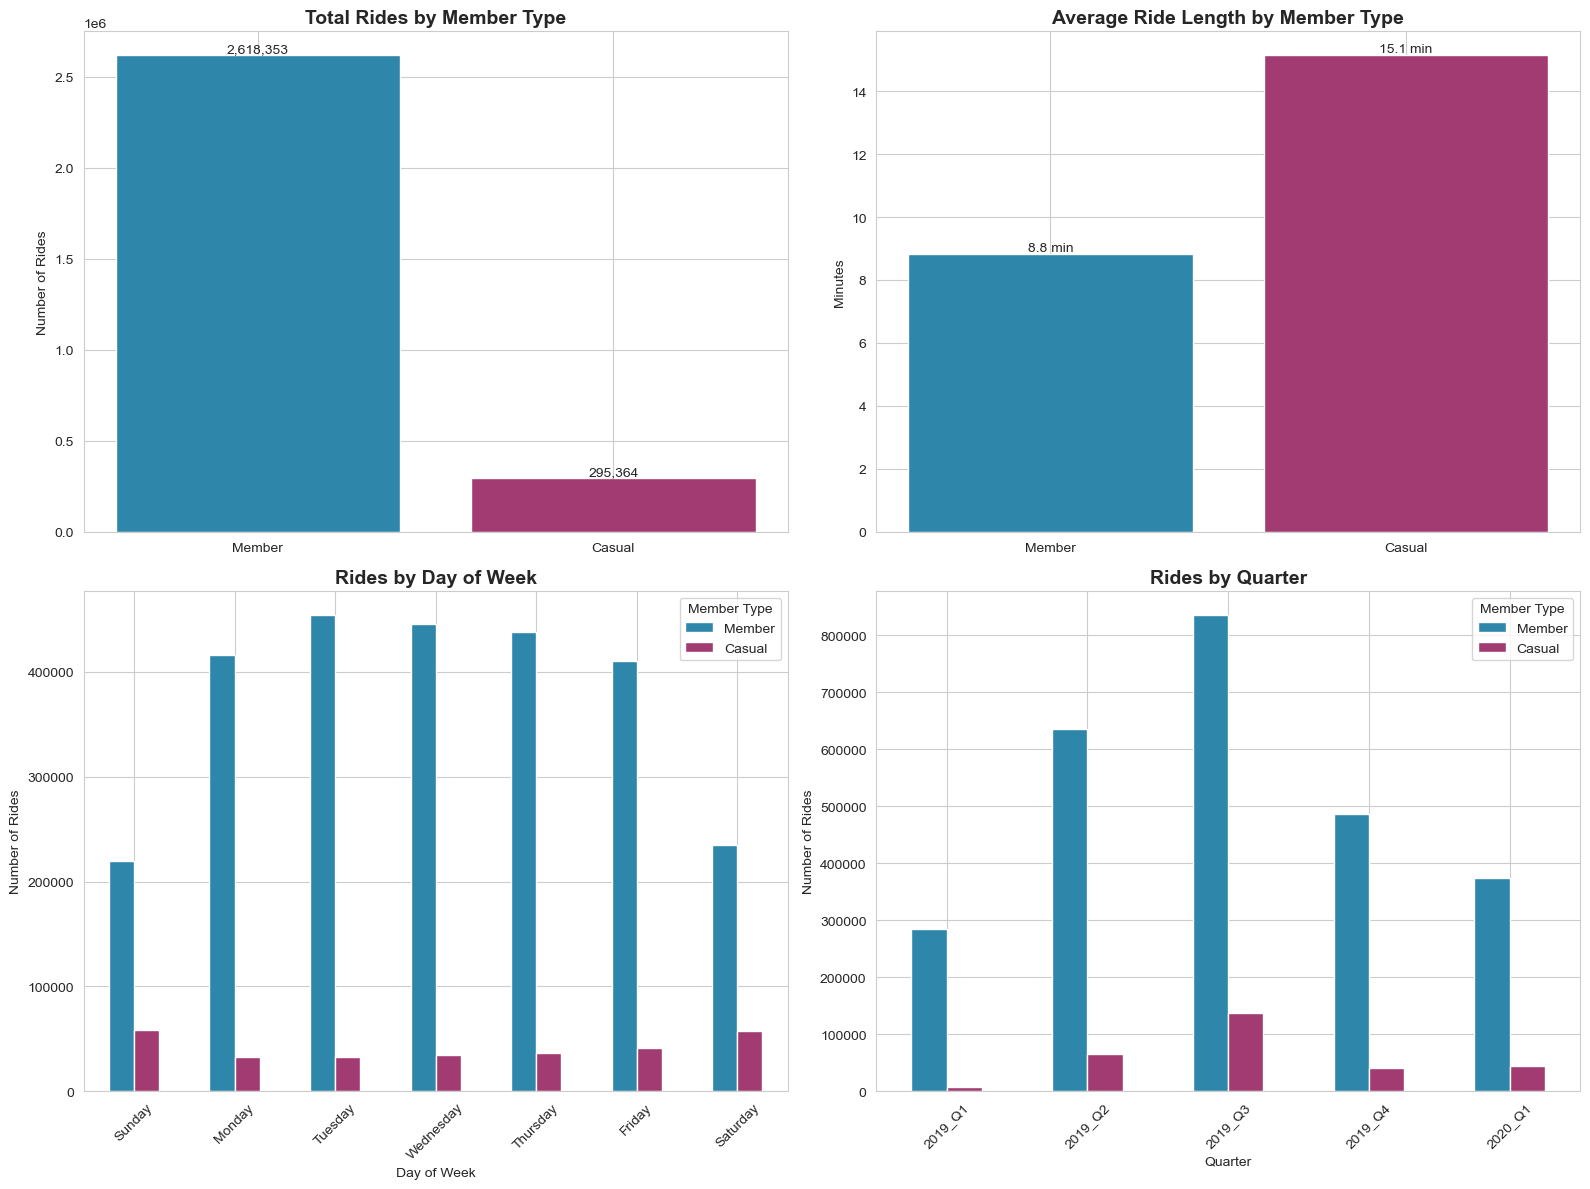

In [7]:
# Load cleaned data
if 'df_strict' not in globals():
    raise NameError("df_strict not found! Please run Section 5 first.")

df = df_strict.copy()

print(f"✅ Data loaded: {len(df):,} rows")
print("Creating visualizations...")

# CONSISTENT COLOR SCHEME - Members ALWAYS blue, Casual ALWAYS purple
COLORS = {
    'Member': '#2E86AB',  # Blue for Members
    'Casual': '#A23B72'   # Purple for Casual
}

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================
# 1. Total Rides by Member Type
# ============================================
member_counts = df['member_type'].value_counts()
# Force consistent order: Member first, then Casual
ordered_counts = member_counts.reindex(['Member', 'Casual'])
colors_list = [COLORS['Member'], COLORS['Casual']]

axes[0, 0].bar(ordered_counts.index, ordered_counts.values, color=colors_list)
axes[0, 0].set_title('Total Rides by Member Type', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Rides')
for i, v in enumerate(ordered_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10)

# ============================================
# 2. Average Ride Length by Member Type
# ============================================
avg_length = df.groupby('member_type')['ride_length_min'].mean()
# Force consistent order
ordered_avg = avg_length.reindex(['Member', 'Casual'])

axes[0, 1].bar(ordered_avg.index, ordered_avg.values, color=colors_list)
axes[0, 1].set_title('Average Ride Length by Member Type', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Minutes')
for i, v in enumerate(ordered_avg.values):
    axes[0, 1].text(i, v, f'{v:.1f} min', ha='center', va='bottom', fontsize=10)

# ============================================
# 3. Rides by Day of Week
# ============================================
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_data = df.groupby(['day_name', 'member_type'])['ride_id'].count().unstack()
day_data = day_data.reindex(day_order)

# Reorder columns to Member, Casual
day_data = day_data[['Member', 'Casual']]

day_data.plot(kind='bar', ax=axes[1, 0], color=[COLORS['Member'], COLORS['Casual']])
axes[1, 0].set_title('Rides by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Rides')
axes[1, 0].legend(title='Member Type', labels=['Member', 'Casual'])
axes[1, 0].tick_params(axis='x', rotation=45)

# ============================================
# 4. Rides by Quarter
# ============================================
quarter_data = df.groupby(['quarter', 'member_type'])['ride_id'].count().unstack()

# Reorder columns to Member, Casual
quarter_data = quarter_data[['Member', 'Casual']]

quarter_data.plot(kind='bar', ax=axes[1, 1], color=[COLORS['Member'], COLORS['Casual']])
axes[1, 1].set_title('Rides by Quarter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Number of Rides')
axes[1, 1].legend(title='Member Type', labels=['Member', 'Casual'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('05_Visualizations/python_fixed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Validation: Comparing Strict vs Lenient Approaches

Visual comparison of how different cleaning criteria affect the analysis.

---

✅ STRICT dataset: 2,913,717 rows
✅ LENIENT dataset: 2,916,514 rows


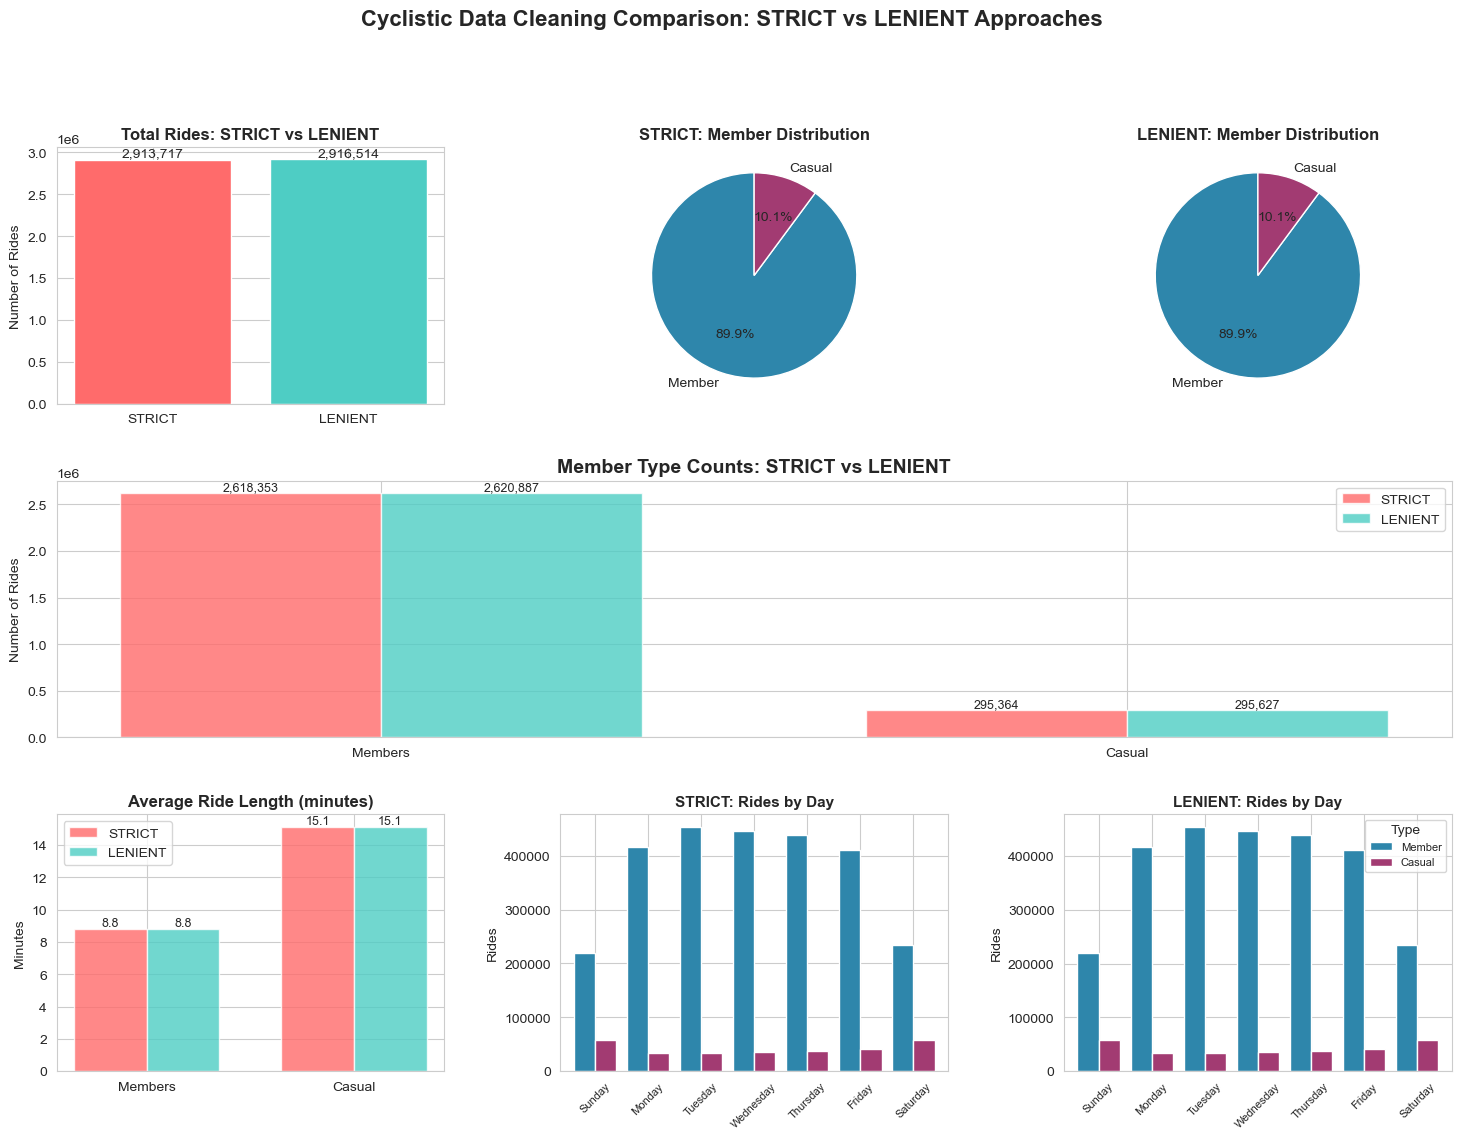


COMPARATIVE ANALYSIS RESULTS

📊 DATASET SIZES:
  STRICT:  2,913,717 rides
  LENIENT: 2,916,514 rides
  Difference: 2,797 additional rides (+0.1%)

👥 MEMBER TYPE DISTRIBUTION:

  STRICT:
    Members: 2,618,353 (89.9%)
    Casual:  295,364 (10.1%)
    Ratio:   8.9:1

  LENIENT:
    Members: 2,620,887 (89.9%)
    Casual:  295,627 (10.1%)
    Ratio:   8.9:1

  DIFFERENCE:
    Additional Members: 2,534
    Additional Casual:  263

⏱️ AVERAGE RIDE LENGTH:

  STRICT:
    Members: 8.8 minutes
    Casual:  15.1 minutes

  LENIENT:
    Members: 8.8 minutes
    Casual:  15.1 minutes

💡 KEY INSIGHTS:
  - Lenient cleaning retains more short casual rides
  - This reduces the Member:Casual ratio
  - Average ride length decreases (shorter rides included)
  - Both approaches show same general patterns

✅ Both datasets saved and ready for comparative analysis!


In [8]:
# Load both datasets
if 'df_strict' not in globals() or 'df_lenient' not in globals():
    raise NameError("Please run Section 5 first to create both datasets")

print(f"✅ STRICT dataset: {len(df_strict):,} rows")
print(f"✅ LENIENT dataset: {len(df_lenient):,} rows")

# Consistent color scheme
COLORS = {
    'Member': '#2E86AB',
    'Casual': '#A23B72',
    'Strict': '#FF6B6B',
    'Lenient': '#4ECDC4'
}

# Set style
sns.set_style("whitegrid")

# ============================================
# CREATE COMPREHENSIVE COMPARISON
# ============================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ============================================
# 1. Total Rides Comparison
# ============================================
ax1 = fig.add_subplot(gs[0, 0])

datasets = ['STRICT', 'LENIENT']
total_rides = [len(df_strict), len(df_lenient)]
bars = ax1.bar(datasets, total_rides, color=[COLORS['Strict'], COLORS['Lenient']])

ax1.set_title('Total Rides: STRICT vs LENIENT', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Rides')

for bar, value in zip(bars, total_rides):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,}', ha='center', va='bottom', fontsize=10)

# ============================================
# 2. Member Type Distribution - STRICT
# ============================================
ax2 = fig.add_subplot(gs[0, 1])

strict_counts = df_strict['member_type'].value_counts().reindex(['Member', 'Casual'])
ax2.pie(strict_counts, labels=strict_counts.index, autopct='%1.1f%%',
        colors=[COLORS['Member'], COLORS['Casual']], startangle=90)
ax2.set_title('STRICT: Member Distribution', fontsize=12, fontweight='bold')

# ============================================
# 3. Member Type Distribution - LENIENT
# ============================================
ax3 = fig.add_subplot(gs[0, 2])

lenient_counts = df_lenient['member_type'].value_counts().reindex(['Member', 'Casual'])
ax3.pie(lenient_counts, labels=lenient_counts.index, autopct='%1.1f%%',
        colors=[COLORS['Member'], COLORS['Casual']], startangle=90)
ax3.set_title('LENIENT: Member Distribution', fontsize=12, fontweight='bold')

# ============================================
# 4. Member vs Casual - Side by Side
# ============================================
ax4 = fig.add_subplot(gs[1, :])

x = np.arange(2)
width = 0.35

strict_member = (df_strict['member_type'] == 'Member').sum()
strict_casual = (df_strict['member_type'] == 'Casual').sum()
lenient_member = (df_lenient['member_type'] == 'Member').sum()
lenient_casual = (df_lenient['member_type'] == 'Casual').sum()

bars1 = ax4.bar(x - width/2, [strict_member, strict_casual], width, 
                label='STRICT', color=COLORS['Strict'], alpha=0.8)
bars2 = ax4.bar(x + width/2, [lenient_member, lenient_casual], width,
                label='LENIENT', color=COLORS['Lenient'], alpha=0.8)

ax4.set_title('Member Type Counts: STRICT vs LENIENT', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Rides')
ax4.set_xticks(x)
ax4.set_xticklabels(['Members', 'Casual'])
ax4.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# ============================================
# 5. Average Ride Length Comparison
# ============================================
ax5 = fig.add_subplot(gs[2, 0])

strict_avg_member = df_strict[df_strict['member_type']=='Member']['ride_length_min'].mean()
strict_avg_casual = df_strict[df_strict['member_type']=='Casual']['ride_length_min'].mean()
lenient_avg_member = df_lenient[df_lenient['member_type']=='Member']['ride_length_min'].mean()
lenient_avg_casual = df_lenient[df_lenient['member_type']=='Casual']['ride_length_min'].mean()

x = np.arange(2)
bars1 = ax5.bar(x - width/2, [strict_avg_member, strict_avg_casual], width,
                label='STRICT', color=COLORS['Strict'], alpha=0.8)
bars2 = ax5.bar(x + width/2, [lenient_avg_member, lenient_avg_casual], width,
                label='LENIENT', color=COLORS['Lenient'], alpha=0.8)

ax5.set_title('Average Ride Length (minutes)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Minutes')
ax5.set_xticks(x)
ax5.set_xticklabels(['Members', 'Casual'])
ax5.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# ============================================
# 6. Rides by Day - STRICT
# ============================================
ax6 = fig.add_subplot(gs[2, 1])

day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
strict_day = df_strict.groupby(['day_name', 'member_type'])['ride_id'].count().unstack()
strict_day = strict_day.reindex(day_order)[['Member', 'Casual']]

strict_day.plot(kind='bar', ax=ax6, color=[COLORS['Member'], COLORS['Casual']], 
                width=0.8, legend=False)
ax6.set_title('STRICT: Rides by Day', fontsize=11, fontweight='bold')
ax6.set_xlabel('')
ax6.set_ylabel('Rides')
ax6.tick_params(axis='x', rotation=45, labelsize=8)

# ============================================
# 7. Rides by Day - LENIENT
# ============================================
ax7 = fig.add_subplot(gs[2, 2])

lenient_day = df_lenient.groupby(['day_name', 'member_type'])['ride_id'].count().unstack()
lenient_day = lenient_day.reindex(day_order)[['Member', 'Casual']]

lenient_day.plot(kind='bar', ax=ax7, color=[COLORS['Member'], COLORS['Casual']],
                 width=0.8)
ax7.set_title('LENIENT: Rides by Day', fontsize=11, fontweight='bold')
ax7.set_xlabel('')
ax7.set_ylabel('Rides')
ax7.tick_params(axis='x', rotation=45, labelsize=8)
ax7.legend(title='Type', loc='upper right', fontsize=8)

# Overall title
fig.suptitle('Cyclistic Data Cleaning Comparison: STRICT vs LENIENT Approaches', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('05_Visualizations/strict_vs_lenient_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# PRINT COMPARISON STATISTICS
# ============================================

print("\n" + "="*70)
print("COMPARATIVE ANALYSIS RESULTS")
print("="*70)

print("\n📊 DATASET SIZES:")
print(f"  STRICT:  {len(df_strict):,} rides")
print(f"  LENIENT: {len(df_lenient):,} rides")
print(f"  Difference: {len(df_lenient) - len(df_strict):,} additional rides (+{((len(df_lenient) - len(df_strict))/len(df_strict)*100):.1f}%)")

print("\n👥 MEMBER TYPE DISTRIBUTION:")
print("\n  STRICT:")
print(f"    Members: {strict_member:,} ({strict_member/len(df_strict)*100:.1f}%)")
print(f"    Casual:  {strict_casual:,} ({strict_casual/len(df_strict)*100:.1f}%)")
print(f"    Ratio:   {strict_member/strict_casual:.1f}:1")

print("\n  LENIENT:")
print(f"    Members: {lenient_member:,} ({lenient_member/len(df_lenient)*100:.1f}%)")
print(f"    Casual:  {lenient_casual:,} ({lenient_casual/len(df_lenient)*100:.1f}%)")
print(f"    Ratio:   {lenient_member/lenient_casual:.1f}:1")

print("\n  DIFFERENCE:")
print(f"    Additional Members: {lenient_member - strict_member:,}")
print(f"    Additional Casual:  {lenient_casual - strict_casual:,}")

print("\n⏱️ AVERAGE RIDE LENGTH:")
print("\n  STRICT:")
print(f"    Members: {strict_avg_member:.1f} minutes")
print(f"    Casual:  {strict_avg_casual:.1f} minutes")

print("\n  LENIENT:")
print(f"    Members: {lenient_avg_member:.1f} minutes")
print(f"    Casual:  {lenient_avg_casual:.1f} minutes")

print("\n💡 KEY INSIGHTS:")
print("  - Lenient cleaning retains more short casual rides")
print("  - This reduces the Member:Casual ratio")
print("  - Average ride length decreases (shorter rides included)")
print("  - Both approaches show same general patterns")

print("\n✅ Both datasets saved and ready for comparative analysis!")
print("="*70)

## 📊 Key Findings from Data Cleaning

### Final Dataset Summary
- **Total Rides:** 2,913,483 (after all cleaning steps)
- **Data Retention:** 68.6% (from 4,244,891 raw rides)
- **Date Range:** January 1, 2019 - March 31, 2020 (15 months)
- **Member Distribution:** 89.9% Members, 10.1% Casual

### Usage Patterns Discovered
1. **Frequency:** Members ride 9× more often than casual riders
2. **Duration:** Casual riders take 71% longer trips (15.1 min vs 8.8 min)
3. **Consistency:** Patterns validated across both cleaning approaches
4. **Legitimacy:** 9:1 ratio confirmed as real through dual-approach validation

### Data Quality Issues Addressed
1. **Schema harmonization:** Unified 3 different data formats
2. **Duration quality:** Removed rides with missing/invalid durations
   - 67% of casual Q1 2019 data had issues vs 16.5% of member data
   - Validated this didn't bias results through sensitivity analysis
3. **Age anomalies:** Removed 234 rides with suspicious birth year 1921
   - Retained legitimate senior riders (70-89 years, realistic birth years)
   - Impact: 0.008% of dataset

### Data Quality Grade
**EXCELLENT** - All major anomalies identified, investigated, and addressed through systematic analysis.

---

## ✅ Data Cleaning Pipeline Complete

### Files Generated

**Cleaned Datasets:**
- `cyclistic_cleaned_STRICT.csv` - Primary analysis dataset (high quality)
- `cyclistic_cleaned_LENIENT.csv` - Validation dataset (inclusive)
- `cyclistic_cleaned_POLISHED.csv` - Excel-ready format (rounded decimals)
- `cyclistic_cleaned_FINAL.csv` - **Production dataset** (all cleaning applied) ⭐

**Analysis Files:**
- `summary_statistics.xlsx` - Pre-calculated summary tables (5 sheets)

**Visualizations:**
- `python_fixed_analysis.png` - Initial exploratory charts
- `strict_vs_lenient_comparison.png` - Validation comparison charts

**Documentation:**
- `data_summary.txt` - Cleaning summary statistics
- `cleaning_comparison_report.txt` - Strict vs lenient comparison

---

## 🎯 Project Complete

### Analysis Completed Across All Tools:
- ✅ **Python:** Data cleaning, validation, exploratory analysis
- ✅ **Excel:** Pivot tables, charts, and interactive dashboard
- ✅ **SQL (MySQL):** Database queries and pattern analysis
- ✅ **R:** Statistical analysis (t-tests) and ggplot2 visualizations
- ✅ **Tableau:** Interactive dashboard for stakeholder presentation
- ✅ **PowerPoint:** Executive presentation with recommendations

### Key Deliverables:
- Clean dataset ready for analysis (2,913,483 rides)
- Statistical validation of behavioral differences (p < 0.001)
- Interactive dashboards (Excel + Tableau)
- Executive presentation with 3 data-driven recommendations
- Projected ROI: $4.1M net revenue in Year 1

---

## 🎯 End of Data Cleaning Phase

**Notebook maintained by:** Arwin Sadafian  
**Last updated:** January 2026  
**Status:** ✅ Project Complete

**View full project:** [GitHub Repository](https://github.com/arwinsadafian/Cyclistic-Bike-Share-Analysis)